In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_squared_error
from util.evaluation import SMAPE
%matplotlib inline

traffic=pd.read_csv('../data/cl_traffic.csv')

traffic=traffic.fillna(0)

traffic.head()

sample_index=np.random.choice(traffic.index,4000,replace=False)
sample_series=[]
for u in sample_index:
#     print('Training...|| {:.2f}'.format(u/tot_len*100)+'%',end='\r')
    sample_series.append(traffic.loc[u][:-4].values)

def diff(x,epsilon=1e-3):
    return((x[1:]-x[:-1])/(x[:-1]+epsilon))


## prepare training and testing data

In [3]:
def split_and_clean(sample_series,train_start,train_end,test_len):
    clean_series=[]
    test_series=[]
    for index in range(len(sample_series)):
        c=np.array(sample_series[index][train_start:train_end])
        test_series.append(sample_series[index][train_end:(train_end+test_len)])
        std=np.std(c)
        mean=np.mean(c)
        c[(c-np.mean(c))>2*std]=mean+2*std
        c[(c-np.mean(c))<-2*std]=mean-2*std
        clean_series.append(c)
    return (clean_series,test_series)

In [4]:

def normalize_X(clean_series):
    recover_dic={}
    scaled_series=[]
    for i in range(len(clean_series)):
        if np.sum(clean_series[i])==0:
            scaled_series.append(np.zeros_like(clean_series[i]))
            recover_dic[i]=(0,0)
        else:
            std=np.std(clean_series[i])
            biased_mean=np.mean(clean_series[i])-3*std

            recover_dic[i]=(std,biased_mean)
            new_series=clean_series[i]-biased_mean
            new_series[new_series<0]=0
            new_series=new_series/(6*std)
            new_series[new_series>1]=1
            scaled_series.append(new_series)
    return (scaled_series,recover_dic)


def normalize_Y(clean_series,recover_dic):
    scaled_series=[]
    for i in range(len(clean_series)):
        (std,biased_mean) = recover_dic[i]
        
        if std==0:
            # ignore all zero cases
#             print(clean_series[i])
            scaled_series.append(np.zeros_like(clean_series[i]))

        else:
            

            new_series=clean_series[i]-biased_mean
            new_series[new_series<0]=0
            new_series=new_series/(6*std)
            new_series[new_series>1]=1
            scaled_series.append(new_series)
    return (scaled_series)

def recover(scaled_series,recover_dic):
    recovered_series=[]
    for i in range(len(scaled_series)):
        std,biased_mean=recover_dic[i]
        new_series=scaled_series[i]*(6*float(std))+biased_mean
        recovered_series.append(new_series)
    return recovered_series

In [5]:
# encode_start=0
# encode_end=150
# decode_len=63

# clean_series,decode_series = split_and_clean(sample_series,encode_start,encode_end,decode_len)


# train_x=clean_series
# train_y=decode_series

# encode_start=200
# encode_end=350
# decode_len=63


# clean_series,decode_series = split_and_clean(sample_series,encode_start,encode_end,decode_len)

# test_x=clean_series
# test_y=decode_series

In [6]:
encode_start=0
encode_end=150
decode_len=63

clean_series,decode_series = split_and_clean(sample_series,encode_start,encode_end,decode_len)
train_x,train_dic = normalize_X(clean_series)
train_y = normalize_Y(decode_series,train_dic)


encode_start=200
encode_end=350
decode_len=63

PERIOD=7

clean_series,decode_series = split_and_clean(sample_series,encode_start,encode_end,decode_len)

test_x,test_dic = normalize_X(clean_series)
test_y = normalize_Y(decode_series,test_dic)

In [7]:
# train_x[0]

In [8]:
def make_one_hots(length,last_pointer=-1):
    pointer=(last_pointer+1) % PERIOD
#     print(pointer)
    one_hots=[]
    one_hot_temp=np.zeros(PERIOD)
    for i in range(length):
        one_hot=one_hot_temp.copy()
        one_hot[pointer]=1
        one_hots.append(one_hot)
        pointer+=1
        pointer=pointer % PERIOD
    return np.array(one_hots)

In [9]:
# trainx=X_loader(train_x,batch_size)

# a,b=next(trainx)

# a.size()


In [10]:
# b[:,2:3,:],b[:,2:3,:]

In [11]:
# b[:,2:3,:]*b[:,2:3,:]

In [166]:
def X_loader(x,batchsize):
    batch=0
    x=np.array(x,dtype=np.float32)
#     x=np.log(x+1)
    one_hots=make_one_hots(len(x[0]))
    
    while batch<(len(x) // batchsize):
        
        data=x[batch*batchsize:(batch+1)*batchsize,:]
        tensor=torch.FloatTensor(np.array(data, dtype=float))
        tensor=tensor.unsqueeze(2).cuda()
        
        feature=torch.FloatTensor(np.array(one_hots)).unsqueeze(0)
        feature=feature.expand((batchsize,feature.size()[1],feature.size()[2])).cuda()
        
        yield(tensor,feature)
        batch+=1

In [167]:

def Y_loader(y,batchsize,length_x):
    batch=0
    y=np.array(y,dtype=np.float32)
#     y=np.log(y+1)
    last_pointer=length_x % PERIOD - 1
    one_hots=make_one_hots(len(y[0]),last_pointer)
    while batch<(len(y) // batchsize):
        
        data=y[batch*batchsize:(batch+1)*batchsize,:]
        tensor=torch.FloatTensor(np.array(data, dtype=float))
        tensor=tensor.unsqueeze(2).cuda()

        feature=torch.FloatTensor(np.array(one_hots)).unsqueeze(0)
        feature=feature.expand((batchsize,feature.size()[1],feature.size()[2])).cuda()
        
        yield(tensor,feature)
        batch+=1

In [14]:
import torch
import torch.nn as nn


In [97]:
# for name, param in decoder.named_parameters():
#     if param.requires_grad:
#         print (name, param.data)

In [16]:
def SMAPE(true,predicted):
    true=true.squeeze()
    predicted=predicted.squeeze()
#     true=torch.exp(true)-1
#     predicted=torch.exp(predicted)-1
    epsilon = 0.1
    summ = torch.abs(true) + torch.abs(predicted) + epsilon
    smape = torch.abs(predicted - true) / summ * 2.0
    return torch.mean(smape)

In [139]:
from torch import optim
from numpy import random as random
epoch=10
indicator=5

# optimizer = optim.RMSprop(model.parameters(), lr=0.001, alpha=0.99, \
#     eps=1e-08, weight_decay=0, momentum=0, centered=False)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0)
input_size=PERIOD
hidden_size=PERIOD
output_size=1
lr=0.01
batch_size=128
encoder=EncoderRNN(input_size,hidden_size,output_size).cuda() if use_cuda else EncoderRNN(1,hidden_size)
decoder=DecoderRNN(input_size,hidden_size,output_size).cuda() if use_cuda else DecoderRNN(1,hidden_size)
teacher_forcing_ratio = 1
encoder_optimizer = optim.SGD(encoder.parameters(), lr=lr)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=lr)

In [ ]:
ps,_,score = valid_iter(test_x, test_y)
for kk in range(12):
    plt.plot(ps[kk][:21])
    plt.title('epoch '+str(0))
plt.show()
print("Validation! Epoch: {}; Loss: {}\n".format(i, np.mean(score)))
for i in range(epoch):
    
    trainx=X_loader(train_x,batch_size)
    trainy=Y_loader(train_y,batch_size,len(train_x[0]))
    
    running_loss_e = 0.0
    running_loss_d = 0.0
#     validation(test_x,test_y)
    for j,(X_batch,x_feature) in enumerate(trainx):
        #Parse loaded batch
        x=X_batch
        y,y_feature=next(trainy)
        
        e_loss,d_loss=train(x, x_feature, y, y_feature, encoder, decoder, encoder_optimizer, \
                  decoder_optimizer, SMAPE)
        running_loss_e += e_loss
        running_loss_d += d_loss
        if (j>0) and (j % indicator == 0):
            print("Epoch: {}; iterations: {}; encoding Loss: {};decoding Loss: {}\n".format(i, j, \
                                running_loss_e / indicator,running_loss_d / indicator))
            running_loss_e = 0.0
            running_loss_d = 0.0
        
    ps,_,score = valid_iter(test_x, test_y)
    for kk in range(12):
        plt.plot(ps[kk][:21])
        plt.title('epoch '+str(i))
    plt.show()
    print("Validation! Epoch: {}; Loss: {}\n".format(i, np.mean(score)))

In [170]:
preds,targets,scores=valid_iter(test_x,test_y)

In [354]:
# scores

In [374]:
testx=X_loader(test_x,batchsize=128)
testy=Y_loader(test_y,batchsize=128,length_x=len(test_x[0]))


In [375]:
a=next(testx)
b=next(testy)

In [297]:
a[1][0,-3:,:]

tensor([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  1.,  0.,  0.,  0.,  0.]], device='cuda:0')

In [300]:
b[1][0,:5,:]

tensor([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  1.],
        [ 1.,  0.,  0.,  0.,  0.,  0.,  0.]], device='cuda:0')

In [32]:
targets[:,:8]

array([[0.45962387, 0.46120766, 0.44457787, ..., 0.46569508, 0.4678068 ,
        0.4564563 ],
       [0.46780175, 1.        , 0.6438196 , ..., 0.46780175, 0.46396485,
        0.44717842],
       [0.27315187, 0.27315187, 0.3995788 , ..., 0.33636534, 0.27315187,
        0.20993839],
       ...,
       [0.45992765, 0.55347604, 0.7405727 , ..., 0.5690674 , 0.64702433,
        0.5690674 ],
       [0.4457808 , 0.39468357, 0.4457808 , ..., 0.5479753 , 0.39468357,
        0.4457808 ],
       [0.45295188, 0.3764918 , 0.2982274 , ..., 0.3503285 , 0.3861903 ,
        0.4058128 ]], dtype=float32)

In [53]:
for i in range(488,500):
    print(preds[i,-7:])

[0.4625609  0.4650167  0.48490563 0.4969792  0.48225525 0.46983668
 0.44968173]
[0.46981913 0.4675432  0.48287112 0.5045009  0.4765608  0.47131458
 0.45077667]
[0.46534857 0.46371442 0.48832187 0.48896626 0.49272898 0.46809736
 0.44723588]
[0.47715044 0.47743595 0.48780122 0.49817663 0.49000221 0.4742357
 0.4533793 ]
[0.47023752 0.46773112 0.48893484 0.48748514 0.4956476  0.46753216
 0.44801694]
[0.44010922 0.4455972  0.48036146 0.49620527 0.47142228 0.4698532
 0.44440943]
[0.45201126 0.45556444 0.48241627 0.49377954 0.47940314 0.4688998
 0.4466435 ]
[0.46548054 0.46175003 0.48312938 0.49421656 0.4827358  0.46599594
 0.4475361 ]
[0.45630333 0.45852903 0.4835073  0.49506247 0.48062342 0.46961865
 0.44749945]
[0.44509935 0.45042163 0.47966382 0.49400672 0.4746838  0.4680031
 0.44557023]
[0.45597097 0.45653915 0.48196507 0.5051703  0.47040662 0.47173277
 0.44864637]
[0.4413083  0.44716394 0.48088086 0.495791   0.47265777 0.46964917
 0.44509202]


In [52]:
preds[1656,2::7]

array([0.48543492, 0.48291636, 0.48291636, 0.48291636, 0.48291636,
       0.48291636, 0.48291636, 0.48291636, 0.48291636], dtype=float32)

In [97]:
# from util.evaluation import SMAPE as cpu_SMAPE
# scores=[]
# for (t,p) in zip(truth,pred):
#     scores.append(cpu_SMAPE(t,p))

In [98]:
# np.mean(scores)

In [27]:
preds=recover(preds,test_dic)
recovered_test_x=recover(test_x,test_dic)
targets=recover(targets,test_dic)

In [28]:
from util.evaluation import SMAPE as cpu_SMAPE
mean_scores=[]


for ID in range(40):

    pred=preds[ID]
    truth=targets[ID]
    scores=[]
    for (t,p) in zip(truth,pred):
        scores.append(cpu_SMAPE(t,p))

    mean_scores.append(np.mean(scores))
np.mean(mean_scores)

0.5278594826010706

[1554.5007 1518.6458 1547.2925 1575.2622 1523.6785 1519.0684 1461.9541
 1464.6715 1477.5975 1541.8481 1575.1504 1523.6643 1519.0662 1461.953
 1464.6714 1477.5974 1541.8481 1575.1504 1523.6643 1519.0662 1461.953
 1464.6714 1477.5974 1541.8481 1575.1504 1523.6643 1519.0662 1461.953
 1464.6714 1477.5974 1541.8481 1575.1504 1523.6643 1519.0662 1461.953
 1464.6714 1477.5974 1541.8481 1575.1504 1523.6643 1519.0662 1461.953
 1464.6714 1477.5974 1541.8481 1575.1504 1523.6643 1519.0662 1461.953
 1464.6714 1477.5974 1541.8481 1575.1504 1523.6643 1519.0662 1461.953
 1464.6714 1477.5974 1541.8481 1575.1504 1523.6643 1519.0662 1461.953 ]


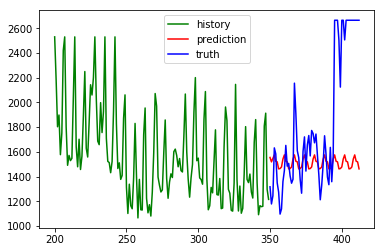

In [29]:
ID=13
# source=sample_series[ID][encode_start:encode_end]
source=recovered_test_x[ID]
pred=preds[ID]
truth=targets[ID]
print(pred)
# for i in range(10):
plt.figure()
plt.plot(np.arange(encode_start,encode_end),source,color='g',label='history')
plt.plot(np.arange(encode_end,encode_end+decode_len),pred,color='r',label='prediction')
plt.plot(np.arange(encode_end,encode_end+decode_len),truth,color='b',label='truth')
plt.legend()

In [61]:
def valid_iter(test_x,test_y):
    testx=X_loader(test_x,batchsize=128)
    testy=Y_loader(test_y,batchsize=128,length_x=len(test_x[0]))

    preds=[]
    targets=[]

    scores=[]
    for j,(X_batch,x_feature) in enumerate(testx):
        #Parse loaded batch
        print(j,end='\r')
        target,y_feature=next(testy)

    
        score,out = valid(X_batch,x_feature, target,y_feature, encoder, decoder, SMAPE)
        out=out.T
        scores.append(score)
        target=target.squeeze().detach().cpu().numpy()
        if j ==0:
            preds=out
            targets=target
        else:
            preds=np.concatenate((preds,out),axis=0)
#             print(preds.shape)
            targets=np.concatenate((targets,target),axis=0)
    return (preds,targets,scores)

In [369]:
# preds
import numpy

def sigmoid(x):
    return 1 / (1 + numpy.exp(-x))
sigmoid(0.)

0.5

In [368]:
sigmoid(0.6)

0.6456563062257954

In [120]:
use_cuda=True
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size,output_size):
        super(EncoderRNN, self).__init__()

        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True, bidirectional=False)
#         self.out = nn.Linear(hidden_size, output_size)
    def forward(self, input_x,feature, hidden):
        #batchsize: bs
        #feature size: fs
        #hidden_size: hs(=bs)
        #input_x:(bs,1,1)
        #feature:(bs,1,fs)
        #hidden:(bs,1,hs)
        gru_input=torch.matmul(input_x,feature)
        #(bs,1,fs)
        output, hidden = self.gru(gru_input, hidden)
        #(bs,1,hs),(bs,1,hs)
        output = torch.sum(feature*output,2,keepdim=True)
        #(bs,1,1)
#         output = torch.sigmoid(output)
         #(bs,1,hs),(bs,1,hs)
        return output, hidden

    def initHidden(self,b_size):
        
#         nn.init.xavier_normal_(self.out)
        paras= nn.init.xavier_normal_(torch.empty(1,b_size,self.hidden_size)).cuda() if use_cuda else \
                nn.init.xavier_normal_(torch.empty(1,b_size,self.hidden_size))
        return paras

class DecoderRNN(nn.Module):
    def __init__(self, input_size,hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True, bidirectional=False)
        self.out = nn.Linear(hidden_size, output_size)


    def forward(self, input_x,feature, hidden):
        #batchsize: bs
        #feature size: fs
        #hidden_size: hs(=bs)
        #input_x:(bs,1,1)
        #feature:(bs,1,fs)
        #hidden:(bs,1,hs)
        gru_input=torch.matmul(input_x,feature)
        #(bs,1,fs)

        output, hidden = self.gru(gru_input, hidden)
        #(bs,1,hs),(bs,1,hs)
        output = torch.sum(feature*output,2,keepdim=True)

        #(bs,1,1)
#         output = torch.sigmoid(output)
         #(bs,1,hs),(bs,1,hs)
        return output, hidden
    def initHidden(self):
        paras= nn.init.xavier_normal_(torch.empty(1,1,self.hidden_size)).cuda() if use_cuda else \
                nn.init.xavier_normal_(torch.empty(1,1,self.hidden_size))
        return paras



def train(input_variable, input_feature, target_variable, target_feature, encoder, decoder, encoder_optimizer, \
          decoder_optimizer, criterion):
    encoder.train()
    decoder.train()
    encoder_hidden = encoder.initHidden(input_variable.size(0))

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_variable.size()[1]
    target_length = target_variable.size()[1]
    
    encoder_outputs = torch.zeros(input_length, encoder.hidden_size)
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs
   
    loss_encoding = 0

    for ei in range(input_length-1):

        encoder_output, encoder_hidden = encoder(
            input_variable[:,ei:(ei+1),:],input_feature[:,ei:(ei+1),:], encoder_hidden)
        loss_encoding += criterion(encoder_output.squeeze(),input_variable[:,ei+1:(ei+2),:].squeeze())
        encoder_outputs[ei] = encoder_output[0,0,:]
#     print('-'*90)
#     print('pred')
#     print(encoder_output.size())
#     print(encoder_output)
#     print('target')
#     print(input_variable[:,ei+1:(ei+2),:].size())
#     print(input_variable[:,ei+1:(ei+2),:])
#     print(criterion(encoder_output.squeeze(),input_variable[:,ei+1:(ei+2),:].squeeze()))
#     print('-'*90)
    #get the first prediction
    encoder_output, encoder_hidden = encoder(input_variable[:,ei+1:(ei+2),:],input_feature[:,ei+1:(ei+2),:],\
                                             encoder_hidden)
    decoder_input = encoder_output
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input
    
    decoder_hidden = encoder_hidden
#     print(input_variable[:,-1,:])
#     print(decoder_hidden)
#     print('_'*90)
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    loss_decoding=0
    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
#             print(decoder_hidden.size())
#             decoder_output, decoder_hidden = decoder(
#                 decoder_input,target_feature[:,di:(di+1),:], decoder_hidden)
        
            
            decoder_output, decoder_hidden = decoder(
                decoder_input,target_feature[:,di:(di+1),:], encoder_hidden)
        
            loss_decoding += criterion(decoder_output.squeeze(), target_variable[:,di:di+1,:].squeeze())
            decoder_input = target_variable[:,di:di+1,:]  # Teacher forcing

    else:
#         print('real start')
#         print(input_variable[:,ei:(ei+1),:])
#         print('encode start')
#         print(decoder_input)
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            
#             print(decoder_hidden.size())
#             decoder_output, decoder_hidden = decoder(
#                 decoder_input,target_feature[:,di:(di+1),:], decoder_hidden)
        
            
            decoder_output, decoder_hidden = decoder(
                decoder_input,target_feature[:,di:(di+1),:], encoder_hidden)

            
            decoder_input = decoder_output
            decoder_input = decoder_input.cuda() if use_cuda else decoder_input
#             print('sizes')
#             print(decoder_output.size(),target_variable[:,di:di+1,:].size())
#             print('pred')
#             print(decoder_output)
#             print('truth')
#             print(target_variable[:,di:di+1,:])
#             print('-'*90)
            loss_decoding += criterion(decoder_output.squeeze(), target_variable[:,di:di+1,:].squeeze())
#     loss=loss_encoding+loss_decoding
    loss=loss_decoding
    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return ((loss_encoding.item() / (input_length-1)),(loss_decoding.item() / target_length))

In [121]:
def valid(input_variable, input_feature, target_variable, target_feature, encoder, decoder, criterion):
    encoder.eval()
    decoder.eval()
    encoder_hidden = encoder.initHidden(input_variable.size(0))
    
    input_length = input_variable.size()[1]
    target_length = target_variable.size()[1]
#     print(target_length)
    
    loss = 0

    for ei in range(input_length):

        encoder_output, encoder_hidden = encoder(
            input_variable[:,ei:(ei+1),:],input_feature[:,ei:(ei+1),:], encoder_hidden)
    
    decoder_input = encoder_output
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input
    
    decoder_hidden = encoder_hidden

#     use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

#     if use_teacher_forcing:
#         # Teacher forcing: Feed the target as the next input
#         for di in range(target_length):
#             decoder_output, decoder_hidden = decoder(
#                 decoder_input, decoder_hidden)
#             loss += criterion(decoder_output, target_variable[:,di:di+1,:])
#             decoder_input = target_variable[:,di:di+1,:]  # Teacher forcing

#     else:
        # Without teacher forcing: use its own predictions as the next input
    outputs=[]
#     print('!'*90)
    for di in range(target_length):
#         decoder_output, decoder_hidden = decoder(
#             decoder_input,target_feature[:,di:(di+1),:], decoder_hidden)


        decoder_output, decoder_hidden = decoder(
            decoder_input,target_feature[:,di:(di+1),:], encoder_hidden)
#         print('-'*90)
#         print('in',decoder_input.size())
#         print('in',target_feature[:,0,:].size())
#         print('hidden',encoder_hidden.size())
#         print('out',decoder_hidden.size())
        
        
#         print('in',decoder_input[0,:,:])
#         print('in',target_feature[0,0,:])
#         print('hidden',encoder_hidden[:,0,:])
#         print('out',decoder_hidden[:,0,:])
#         print('out',decoder_output[0,:,:])
        decoder_input = decoder_output
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input
        outputs.append(decoder_output.squeeze().detach().cpu().numpy())
#         print(decoder_output.size(), target_variable[:,di:di+1,:].size())
#         print(decoder_output.size(), target_variable[:,di:di+1,:].size())
        loss += criterion(decoder_output, target_variable[:,di:di+1,:])


    return (loss.item() / target_length,np.array(outputs))

In [84]:
preds[0]

array([0.5090716 , 0.50754863, 0.49179465, 0.49177837, 0.48591298,
       0.482741  , 0.46966267, 0.47118858, 0.4909701 , 0.48962954,
       0.4917352 , 0.4859075 , 0.4827402 , 0.46966234, 0.47118852,
       0.49097002, 0.48962954, 0.4917352 , 0.4859075 , 0.4827402 ,
       0.46966234, 0.47118852, 0.49097002, 0.48962954, 0.4917352 ,
       0.4859075 , 0.4827402 , 0.46966234, 0.47118852, 0.49097002,
       0.48962954, 0.4917352 , 0.4859075 , 0.4827402 , 0.46966234,
       0.47118852, 0.49097002, 0.48962954, 0.4917352 , 0.4859075 ,
       0.4827402 , 0.46966234, 0.47118852, 0.49097002, 0.48962954,
       0.4917352 , 0.4859075 , 0.4827402 , 0.46966234, 0.47118852,
       0.49097002, 0.48962954, 0.4917352 , 0.4859075 , 0.4827402 ,
       0.46966234, 0.47118852, 0.49097002, 0.48962954, 0.4917352 ,
       0.4859075 , 0.4827402 , 0.46966234], dtype=float32)

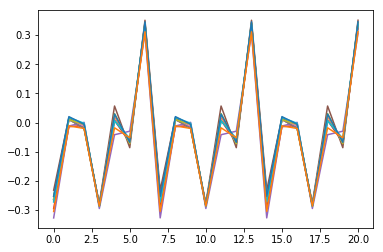

In [169]:
for i in range(12):
    plt.plot(preds[i][:21])
#     plt.plot(preds[213])

In [164]:
preds[45]

array([-0.2906543 ,  0.00244739,  0.00105445, -0.29007328,  0.00051828,
       -0.05483976,  0.32942048, -0.29045188,  0.00248676,  0.00105351,
       -0.2900731 ,  0.00051828, -0.05483976,  0.32942048, -0.29045188,
        0.00248676,  0.00105351, -0.2900731 ,  0.00051828, -0.05483976,
        0.32942048, -0.29045188,  0.00248676,  0.00105351, -0.2900731 ,
        0.00051828, -0.05483976,  0.32942048, -0.29045188,  0.00248676,
        0.00105351, -0.2900731 ,  0.00051828, -0.05483976,  0.32942048,
       -0.29045188,  0.00248676,  0.00105351, -0.2900731 ,  0.00051828,
       -0.05483976,  0.32942048, -0.29045188,  0.00248676,  0.00105351,
       -0.2900731 ,  0.00051828, -0.05483976,  0.32942048, -0.29045188,
        0.00248676,  0.00105351, -0.2900731 ,  0.00051828, -0.05483976,
        0.32942048, -0.29045188,  0.00248676,  0.00105351, -0.2900731 ,
        0.00051828, -0.05483976,  0.32942048], dtype=float32)

In [163]:
preds,targets,scores=valid_iter(test_x,test_y)